# Lab 10 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

In this lab, we perform an exercise to classify dog and cat images using a CNN model and fine-tuning a pretrained CNN model.

## 1. Obtain the Data

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

### Make small dataset

In [71]:
import os, shutil, pathlib

original_dir = pathlib.Path("../data/kaggle_dogs_vs_cats/train")
new_base_dir = pathlib.Path("../data/kaggle_dogs_vs_cats_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [3]:
data_folder = pathlib.Path('../data/kaggle_dogs_vs_cats_small')

### Split Dataset (train/validation/test)

In [191]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    shuffle=False,
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


## 2. EDA: Explore the data with relevant graphs, statistics and insights

### Data Exploration

In [62]:
type(train_dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [34]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [79]:
data_batch[0]

<tf.Tensor: shape=(180, 180, 3), dtype=float32, numpy=
array([[[114.      , 100.      ,  91.      ],
        [114.      , 100.      ,  91.      ],
        [114.      , 100.      ,  91.      ],
        ...,
        [100.47229 ,  81.47229 ,  75.47229 ],
        [107.89826 ,  88.89826 ,  82.89826 ],
        [101.667244,  84.54386 ,  76.60555 ]],

       [[114.625   , 100.625   ,  91.625   ],
        [114.625   , 100.625   ,  91.625   ],
        [114.625   , 100.625   ,  91.625   ],
        ...,
        [105.04175 ,  86.04175 ,  80.04175 ],
        [108.06665 ,  88.8531  ,  82.63956 ],
        [100.32118 ,  80.77222 ,  71.51111 ]],

       [[115.      , 101.      ,  92.      ],
        [115.      , 101.      ,  92.      ],
        [115.      , 101.      ,  92.      ],
        ...,
        [104.70841 ,  84.70841 ,  77.70841 ],
        [102.06697 ,  81.34091 ,  74.09889 ],
        [ 99.89179 ,  75.247345,  67.98889 ]],

       ...,

       [[ 98.96678 ,  77.96678 ,  60.966785],
        [ 99.

In [64]:
# print data range
print('Image data range')
print(f'Min: {data_batch.numpy().min()}')
print(f'Max: {data_batch.numpy().max()}')

Image data range
Min: 0.0
Max: 255.0


- The `image_dataset_from_directory` function is used, resulting in a `batch_size` of 32 for one data batch.
- The image size is 180x180.
- Each data has RGB values, so it has the shape of 180x180x3.
- The minimum value for one pixel is 0, and the maximum value is 255.

### Plot the data as images

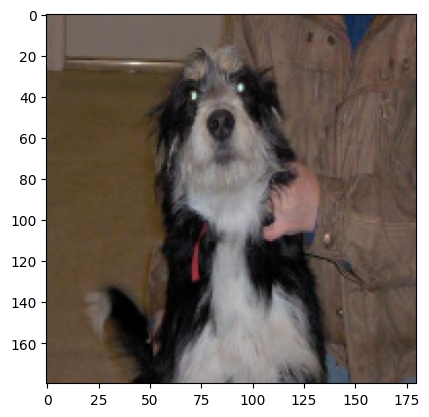

In [74]:
plt.imshow(data_batch[0].numpy().astype("uint8"))

In [66]:
def plot_image(image_data):
    plt.imshow(image_data.numpy().astype("uint8"))
    plt.axis("off")

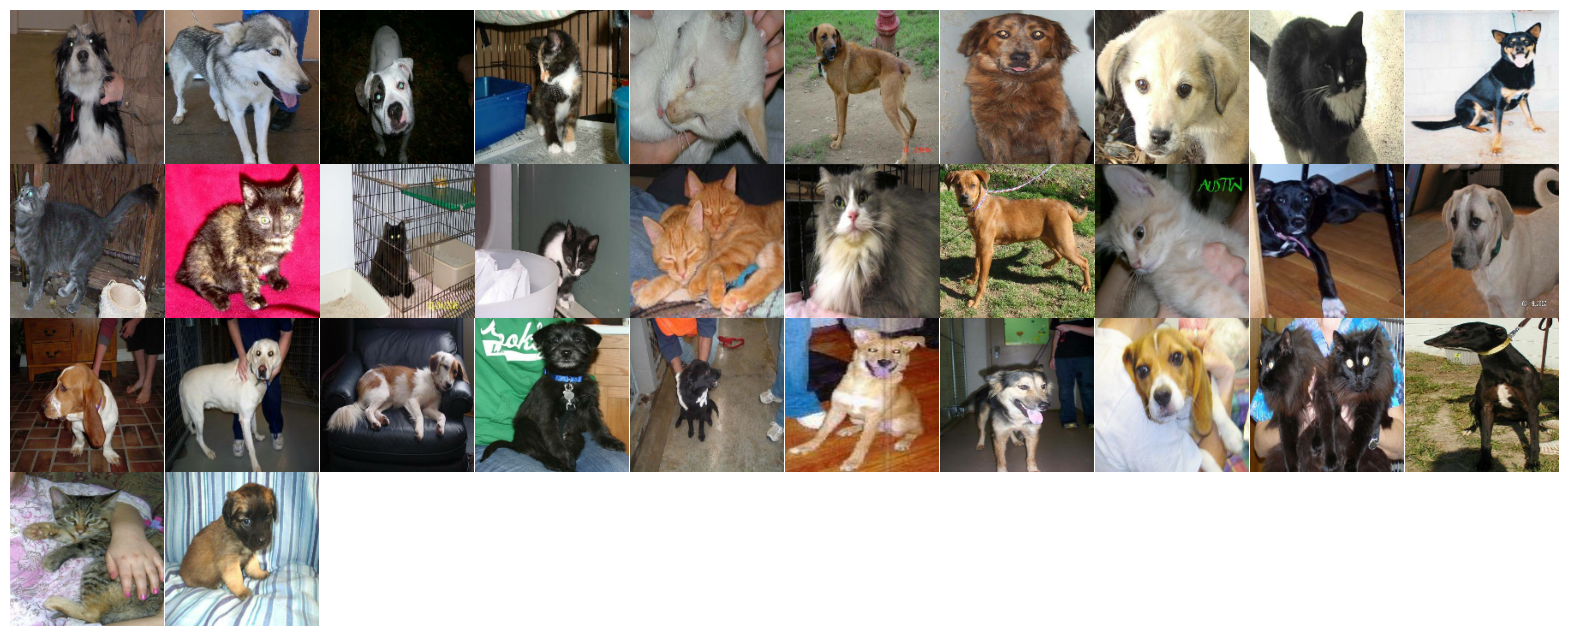

In [73]:
plt.figure(figsize=(20, 20))
for idx, image_data in enumerate(data_batch):
    plt.subplot(10, 10, idx + 1)
    plot_image(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [75]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1])>

In [111]:
class_names = train_dataset.class_names
class_names

['cat', 'dog']

- Images for the first batch of 32 out of 2000 training data were displayed.
- Each image data is a picture of either a cat or a dog.
- Class 0 represents cat, and class 1 represents dog.

### Pixel Distribution

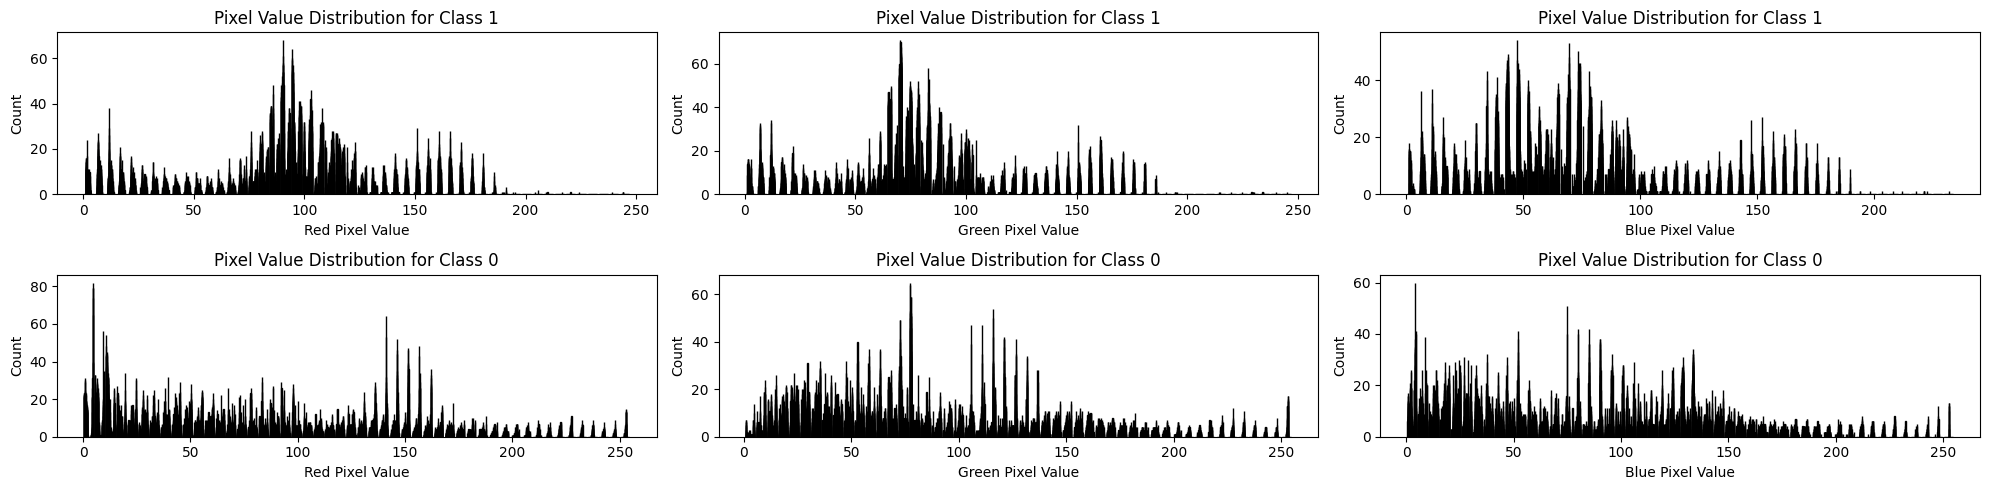

In [78]:
# Plot the distribution of pixel values
fig, axes = plt.subplots(2, 3, figsize=(20, 5))

# pixel distribution for class 1
for i in range(3):
    plt.sca(axes[0][i])
    plt.hist(data_batch[0, :, :, i].numpy(), bins=50, edgecolor='black')
    plt.title(f'Pixel Value Distribution for Class {labels_batch[0]}')
    if i == 0:
        plt.xlabel('Red Pixel Value')
    elif i == 1:
        plt.xlabel('Green Pixel Value')
    else:
        plt.xlabel('Blue Pixel Value')
    plt.ylabel('Count')

# pixel distribution for class 0
for i in range(3):
    plt.sca(axes[1][i])
    plt.hist(data_batch[3, :, :, i].numpy(), bins=50, edgecolor='black')
    plt.title(f'Pixel Value Distribution for Class {labels_batch[3]}')
    if i == 0:
        plt.xlabel('Red Pixel Value')
    elif i == 1:
        plt.xlabel('Green Pixel Value')
    else:
        plt.xlabel('Blue Pixel Value')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

- The distribution of pixel values was illustrated with an example from each class.
- Pixels consist of RGB values, and the distribution for red, green, and blue values was plotted separately.
- For class 1 (dog), pixel values are most densely distributed between 50 and 100 across all RGB.
- For class 0 (cat), pixel values are relatively evenly distributed.

### Class Imbalance

In [112]:
import plotly.express as px
import plotly.offline as po

po.offline.init_notebook_mode()

# Count the occurrences of each class
class_counts = np.zeros(2)
for data_batch, labels_batch in train_dataset:
    class_counts += np.bincount(labels_batch.numpy())

# Plot a piechart using plotly
fig = px.pie(values=class_counts, names=class_names, title='Percentage of samples per label')
fig.show()

- The pie chart represents the number and proportion of data per class in the training dataset.
- Class 0 and class 1 each make up 50% of the data.
- Since an equal number was intentionally inserted at the point of creating the small dataset, it can be seen that the data has been well prepared.

## 3. Train two networks

### 3-1. Define a Neural Network of your choice

In [80]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [81]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [82]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [83]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 25s 391ms/step - loss: 0.6970 - accuracy: 0.4920 - val_loss: 0.6915 - val_accuracy: 0.6140
Epoch 2/30
63/63 [==============================] - 27s 420ms/step - loss: 0.6903 - accuracy: 0.5395 - val_loss: 0.6668 - val_accuracy: 0.5750
Epoch 3/30
63/63 [==============================] - 27s 432ms/step - loss: 0.6484 - accuracy: 0.6015 - val_loss: 0.6485 - val_accuracy: 0.6040
Epoch 4/30
63/63 [==============================] - 25s 402ms/step - loss: 0.6190 - accuracy: 0.6505 - val_loss: 0.6604 - val_accuracy: 0.5980
Epoch 5/30
63/63 [==============================] - 25s 398ms/step - loss: 0.5964 - accuracy: 0.6635 - val_loss: 0.6607 - val_accuracy: 0.6260
Epoch 6/30
63/63 [==============================] - 25s 402ms/step - loss: 0.5712 - accuracy: 0.6935 - val_loss: 0.6540 - val_accuracy: 0.6350
Epoch 7/30
63/63 [==============================] - 25s 398ms/step - loss: 0.5462 - accuracy: 0.7210 - val_loss: 0.7159 - val_accuracy: 0.6080

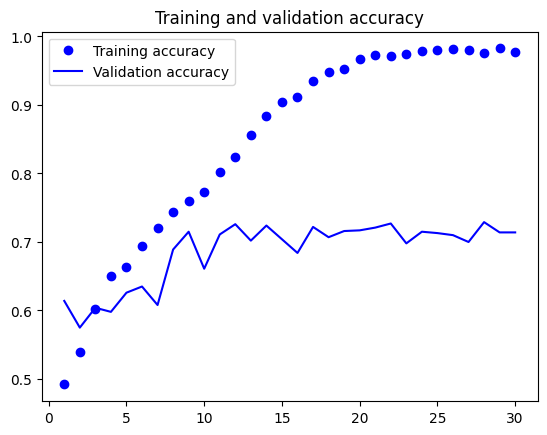

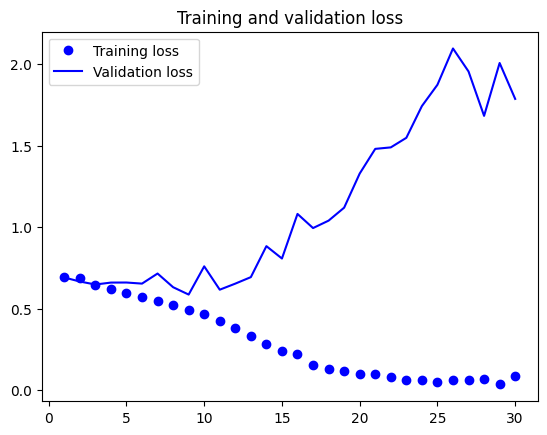

In [84]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### 3-2. Fine-Tune VGG16 

In [25]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [26]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [27]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [28]:
inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_finetune = keras.Model(inputs, outputs)

In [29]:
model_finetune.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               3277

In [30]:
model_finetune.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks_finetune = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history_finetune = model_finetune.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks_finetune)

Epoch 1/30


63/63 [==============================] - 111s 2s/step - loss: 2.0613 - accuracy: 0.8570 - val_loss: 0.8491 - val_accuracy: 0.9310
Epoch 2/30
63/63 [==============================] - 112s 2s/step - loss: 0.1301 - accuracy: 0.9830 - val_loss: 0.5907 - val_accuracy: 0.9430
Epoch 3/30
63/63 [==============================] - 111s 2s/step - loss: 0.0081 - accuracy: 0.9985 - val_loss: 0.5387 - val_accuracy: 0.9470
Epoch 4/30
63/63 [==============================] - 111s 2s/step - loss: 3.3050e-05 - accuracy: 1.0000 - val_loss: 0.5337 - val_accuracy: 0.9510
Epoch 5/30
63/63 [==============================] - 111s 2s/step - loss: 2.1491e-06 - accuracy: 1.0000 - val_loss: 0.5312 - val_accuracy: 0.9500
Epoch 6/30
63/63 [==============================] - 110s 2s/step - loss: 1.3575e-06 - accuracy: 1.0000 - val_loss: 0.5303 - val_accuracy: 0.9500
Epoch 7/30
63/63 [==============================] - 110s 2s/step - loss: 1.0965e-06 - accuracy: 1.0000 - val_loss: 0.5297 - val_accuracy: 0.9510
Epoch 8/

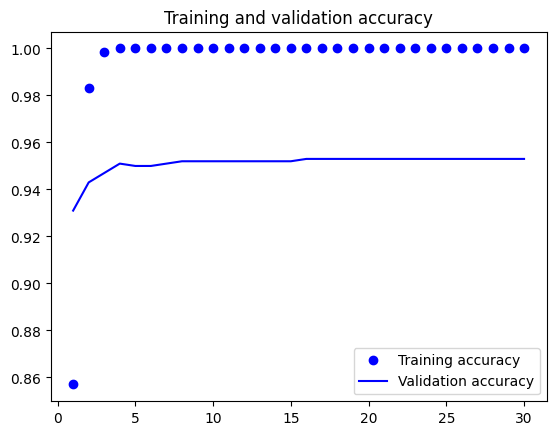

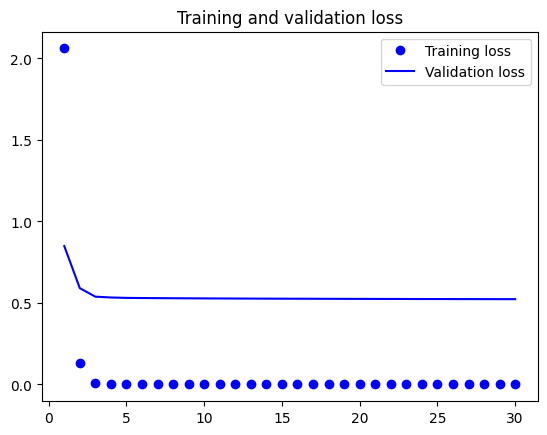

In [31]:
acc = history_finetune.history["accuracy"]
val_acc = history_finetune.history["val_accuracy"]
loss = history_finetune.history["loss"]
val_loss = history_finetune.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## 4. Explore the relative performance of the models

### 4-1. Accuracy

#### CNN from the scratch

In [196]:
best_model_scratch = keras.models.load_model("./models/convnet_from_scratch.keras")
test_loss, test_acc = best_model_scratch.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 5s 81ms/step - loss: 0.6191 - accuracy: 0.7025
Test accuracy: 0.702


#### Fine-tuned VGG16

In [197]:
best_model_finetune = keras.models.load_model("./models/fine_tuning.keras")
test_loss, test_acc = best_model_finetune.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 64s 1s/step - loss: 0.5163 - accuracy: 0.9520
Test accuracy: 0.952


### 4-2. Confusion Metric

#### CNN from the scratch

In [209]:
# get the true classes of the test dataset
y_test_classes = []

for data, labels_batch in test_dataset:
    y_test_classes.extend(labels_batch.numpy().astype(int))
y_test_classes = np.array(y_test_classes)

In [210]:
# predict classes for the test dataset
y_pred_test_scratch = best_model_scratch.predict(test_dataset)
y_pred_class_scratch = (y_pred_test_scratch > 0.5).astype("int32")
y_pred_class_scratch = y_pred_class_scratch.reshape(-1)

 1/63 [..............................] - ETA: 5s

63/63 [==============================] - 5s 79ms/step


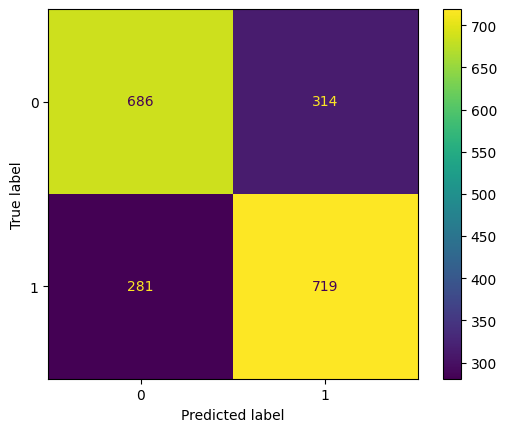

In [211]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_classes, y_pred_class_scratch)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#### Fine-tuned VGG16

In [212]:
# predict classes for the test dataset
y_pred_test_finetune = best_model_finetune.predict(test_dataset)
y_pred_class_finetune = (y_pred_test_finetune > 0.5).astype("int32")
y_pred_class_finetune = y_pred_class_finetune.reshape(-1)

63/63 [==============================] - 65s 1s/step


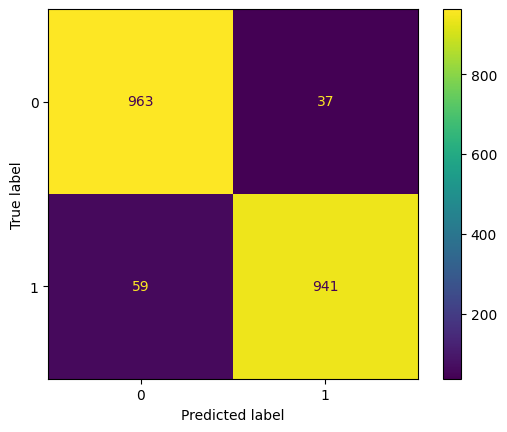

In [213]:
cm = confusion_matrix(y_test_classes, y_pred_class_finetune)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### 4-3. Precision, Recall, F1-score

#### CNN from the scratch

In [214]:
from sklearn.metrics import classification_report

print(classification_report(y_test_classes, y_pred_class_scratch))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70      1000
           1       0.70      0.72      0.71      1000

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000



#### Fine-tuned VGG16

In [215]:
print(classification_report(y_test_classes, y_pred_class_finetune))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1000
           1       0.96      0.94      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



### 4-4. Precision-recall curve

#### CNN from the scratch

In [246]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test_classes, y_pred_test_scratch)

print(precisions[:5])
print(recalls[:5])
print(thresholds[:5])

[0.5        0.50025013 0.5005005  0.50075113 0.500501  ]
[1.    1.    1.    1.    0.999]
[0.00089267 0.00105542 0.00156743 0.00305794 0.00322779]


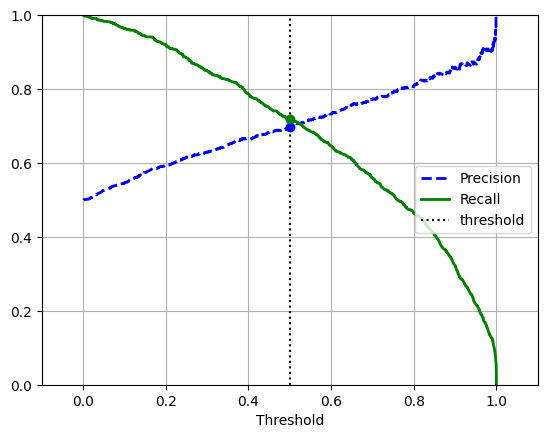

In [248]:
threshold = 0.50
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-0.1, 1.1, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

#### Fine-tuned VGG16

In [225]:
precisions, recalls, thresholds = precision_recall_curve(y_test_classes, y_pred_test_finetune)

print(precisions[:5])
print(recalls[:5])
print(thresholds[:5])

[0.5        0.50684237 0.50709939 0.50735667 0.50761421]
[1. 1. 1. 1. 1.]
[0.0000000e+00 1.2690319e-38 1.3929722e-38 1.6223984e-38 2.0063773e-38]


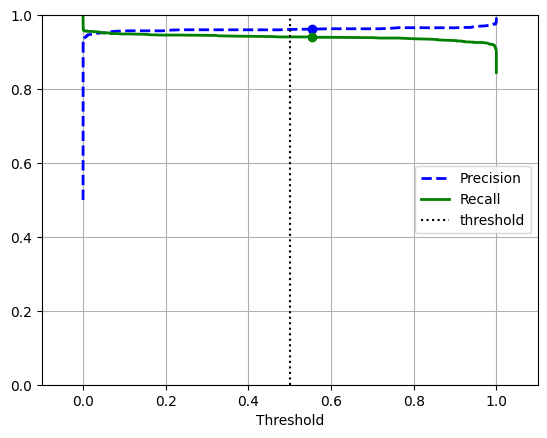

In [230]:
threshold = 0.50
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-0.1, 1.1, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

### 4-5. Explore specific examples in which the model failed to predict correctly.

#### CNN from the scratch

In [281]:
failed_scratch = np.where(y_test_classes != y_pred_class_scratch)[0]
# get the first 3 indices of failed images
print(f'failed indices: {failed_scratch[:3]}')
# get the original classes of the first 3 failed images
print(f'original class: {y_test_classes[failed_scratch[:3]]}')
# get the predicted classes of the first 3 failed images
print(f'predicted class: {y_pred_class_scratch[failed_scratch[:3]]}')

failed indices: [1 5 7]
original class: [0 0 0]
predicted class: [1 1 1]


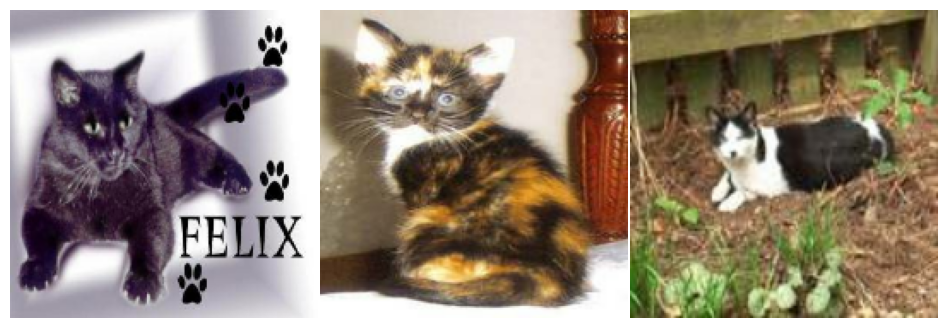

In [276]:
plt.figure(figsize=(20, 20))
for idx, image_data in enumerate(test_dataset.unbatch()):
    if idx in failed_scratch[:3]:
        plt.subplot(5, 5, failed_scratch.tolist().index(idx) + 1)
        plot_image(image_data[0])
    if idx == failed_scratch[2]:
        break
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

#### Fine-tuned VGG16

In [282]:
failed_finetune = np.where(y_test_classes != y_pred_class_finetune)[0]
# get the first 3 indices of failed images
print(f'failed indices: {failed_finetune[:3]}')
# get the original classes of the first 3 failed images
print(f'original class: {y_test_classes[failed_finetune[:3]]}')
# get the predicted classes of the first 3 failed images
print(f'predicted class: {y_pred_class_finetune[failed_finetune[:3]]}')

failed indices: [ 37 116 119]
original class: [0 0 0]
predicted class: [1 1 1]


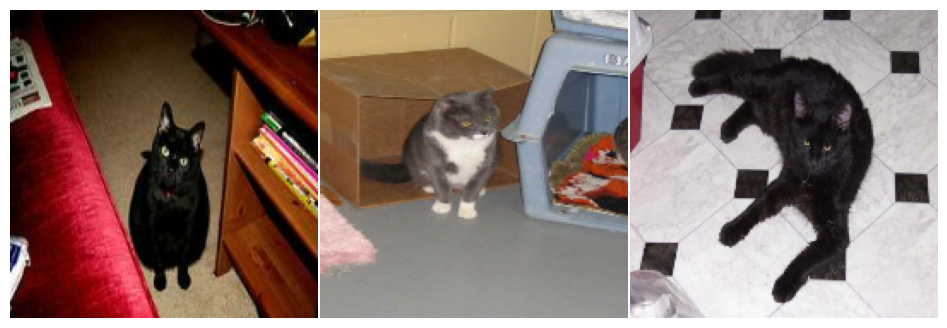

In [278]:
plt.figure(figsize=(20, 20))
for idx, image_data in enumerate(test_dataset.unbatch()):
    if idx in failed_finetune[:3]:
        plt.subplot(5, 5, failed_finetune.tolist().index(idx) + 1)
        plot_image(image_data[0])
    if idx == failed_finetune[2]:
        break
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

- The indices, classes, and images predicted differently by the two models were output.
- The third image from the first model and the second image from the second model could be considered to resemble a dog upon visual inspection.

## 5. Conclusions

### Model Configuration
1. CNN from the scratch
- (conv_layer + max_pooling) * 4 + conv_layer + dense(1)
- trainable parameter: 991,041
- The final layer consists of a single neuron with a sigmoid activation function for binary classification.
2. Fine-tuned VGG16
- VGG16 (pretrained) + Dense (256) + Dense (1)
- the last 4 layers of VGG16 are made trainable
- trainable parameter: 10,356,737

### Best Model
1. CNN from the scratch
- The validation loss is lowest around epoch 9, indicating that this is the best model.
- After that point, overfitting occurs, causing the loss to increase.
2. Fine-tuned VGG16
- The validation loss almost reaches its lowest at epoch 3 and then remains stable.
- Considering overfitting, the best model is when the epoch is at 3.

### Accuracy
Number of Test Dataset = 2000
1. CNN from the scratch
- Accuracy: (686 (TF) + 719 (FN)) / 2000 = 0.7025

2. Fine-tuned VGG16
- Accuracy: (963 (TF) + 941 (FN)) / 2000 = 0.952


- From the perspective of accuracy, the fine-tuned VGG16 model demonstrates significantly better performance with an accuracy of 0.95, compared to the CNN from scratch model, which has an accuracy of 0.70.

### Precision, Recall, and F1-score

1. CNN from the scratch

| class | precision | recall | f1-score |
|-------|-----------|--------|----------|
| 0 (cat) | 0.71 | 0.69 | 0.70 |
| 1 (dog) | 0.70 | 0.72 | 0.71 |

2. Fine-tuned VGG16

| class | precision | recall | f1-score |
|-------|-----------|--------|----------|
| 0 (cat) | 0.94 | 0.96 | 0.95 |
| 1 (dog) | 0.96 | 0.94 | 0.95 |

- Each model exhibits similar classification performance for classes 0 and 1, with precision and recall values showing minimal differences between the classes.
- When comparing the basic CNN model to the fine-tuned VGG16 model, the fine-tuned VGG16 model outperforms in all aspects.
- The classification performance shown is based on predicting the test set with a threshold of 0.5 for the probabilities of the two classes.
- For the precision-recall curve of the scratch CNN model, increasing the threshold significantly improves precision but reduces recall, while decreasing the threshold has the opposite effect.
- In the case of the fine-tuned VGG16 model, the performance is almost above 0.9 so that adjusting the threshold does not significantly change the performance.

### Summary
- The VGG16 model is a deep neural network with 13 convolutional layers, originally designed for classifying 1,000 different images in the ImageNet challenge.
- The experimental results demonstrate that weights pre-trained for ImageNet can also perform well on other image classification tasks when fine-tuned.